In [1]:
import timeit
start_time = timeit.default_timer()

In [2]:
## Import libraries
import time
import datetime
import pandas as pd
import io
import matplotlib.pyplot as plt

# GSEF forecast

In [3]:
gsef= pd.read_csv('gsef_output/historical_gsef.csv', parse_dates=['Date'], dayfirst=True)

This analysis demonstrates the use of ARIMA models to predict the prices of the NN (L) Global Sustainable Equity fund.

## Imports & data loading

In [4]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np

In [5]:
gsef_selected= gsef[['Date', 'Close']]

In [6]:
y = gsef_selected[['Close']].values

## Data splitting

In [7]:
train_data, test_data = gsef_selected[0:int(len(gsef_selected)*0.65)], gsef_selected[int(len(gsef_selected)*0.65):]

# Load/split your data
y_train, y_test = train_test_split(y, train_size= len(train_data))

## Pre-modeling analysis

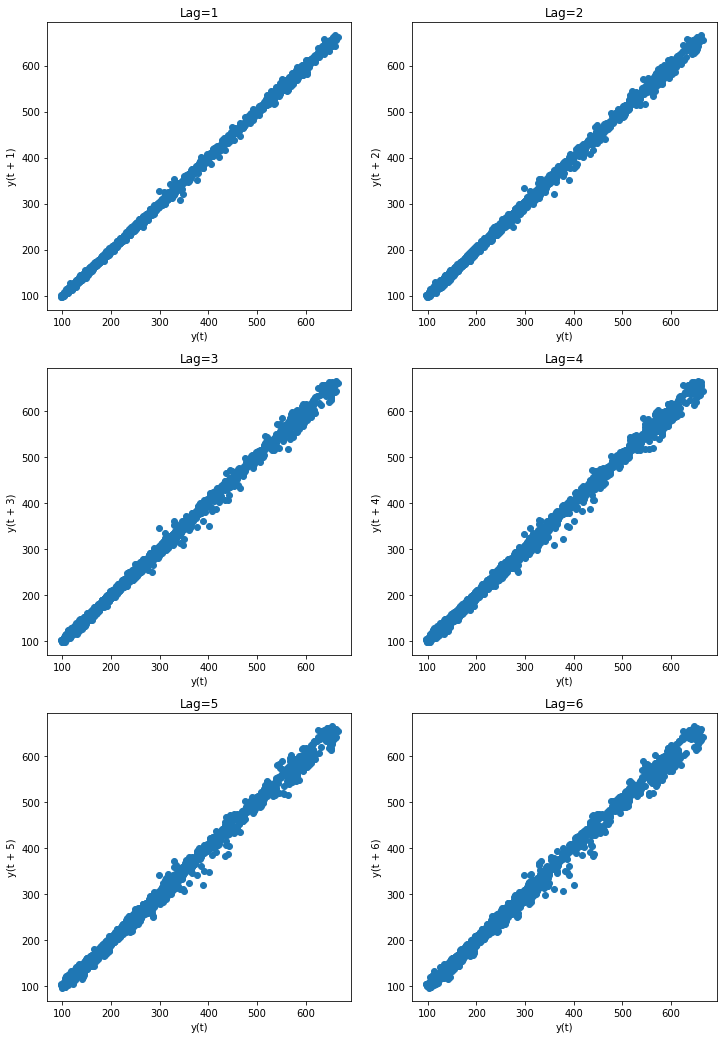

In [8]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(3, 2, figsize=(12, 18))
plt.title('GSEF Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(gsef_selected['Close'], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")

#plt.show()

## Estimating the differencing term

An integrative term, d, is typically only used in the case of non-stationary data. Stationarity in a time series indicates that a series’ statistical attributes, such as mean, variance, etc., are constant over time (i.e., it exhibits low heteroskedasticity).

A stationary time series is far more easy to learn and forecast from. With the d parameter, we can force the ARIMA model to adjust for non-stationarity on its own, without having to worry about doing so manually.

To make our data stationary in the case of ARIMA models, we estimate the appropriate differencing (d) value, and we use the estimated differencing value to difference the time series accordingly.

In [9]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing value: {n_diffs}")

Estimated differencing value: 2


## Fitting our model

In [10]:
auto = pm.auto_arima(y_train, d=n_diffs, seasonal=True, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=2.69 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=16275.441, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=15441.518, Time=0.16 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=15013.702, Time=0.14 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=14793.055, Time=0.18 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=14698.128, Time=0.19 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=14628.301, Time=0.27 sec
 ARIMA(6,2,0)(0,0,0)[0]             : AIC=14530.880, Time=0.45 sec
 ARIMA(6,2,1)(0,0,0)[0]             : AIC=inf, Time=2.14 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=1.46 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept   : AIC=14532.879, Time=0.75 sec

Best model:  ARIMA(6,2,0)(0,0,0)[0]          
Total fit time: 8.895 seconds


## Updating the model

In [11]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
from math import sqrt

model = auto  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean absolute error: {mean_absolute_error(y_test, forecasts)}")

# Mean Absolute Percent
def mean_absolute_percent_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

mape= mean_absolute_percent_error(y_test, forecasts) #same as MAE but percentage
print(f"\nMean absolute percent error (MAPE):", mape)

print(f"\nMean squared error: {mean_squared_error(y_test, forecasts)}")

print(f"\nRoot mean squared error (RMSE): {sqrt(mean_squared_error(y_test, forecasts))}")

print(f"\nSMAPE: {smape(y_test, forecasts)}")

Mean absolute error: 3.010337325314624

Mean absolute percent error (MAPE): 0.32135655897533877

Mean squared error: 21.025219452436062

Root mean squared error (RMSE): 4.585326537165708

SMAPE: 0.8136275829973559


In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5533
Model:               SARIMAX(6, 2, 0)   Log Likelihood              -14042.827
Date:                Sun, 05 Jun 2022   AIC                          28099.654
Time:                        22:48:03   BIC                          28145.981
Sample:                             0   HQIC                         28115.808
                               - 5533                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8638      0.005   -161.218      0.000      -0.874      -0.853
ar.L2         -0.6844      0.008    -86.890      0.000      -0.700      -0.669
ar.L3         -0.5814      0.009    -64.207      0.000      -0.599      -0.564
ar.L4         -0.4429      0.009    -50.451      0.000      -0.460      -0.426
ar.L5         -0.2752      0.007    -37.056      0.000      -0.290      -0.261
ar.L6         -0.2150      0.005    -42.451      0.000      -0.225      -0.205
sigma2         9.3872      0.068    137.375      0.000       9.253       9.521
===================================================================================
Ljung-Box (L1) (Q):                   2.67   Jarque-Bera (JB):             42053.80
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               5.94   Skew:                             0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Viewing forecasts

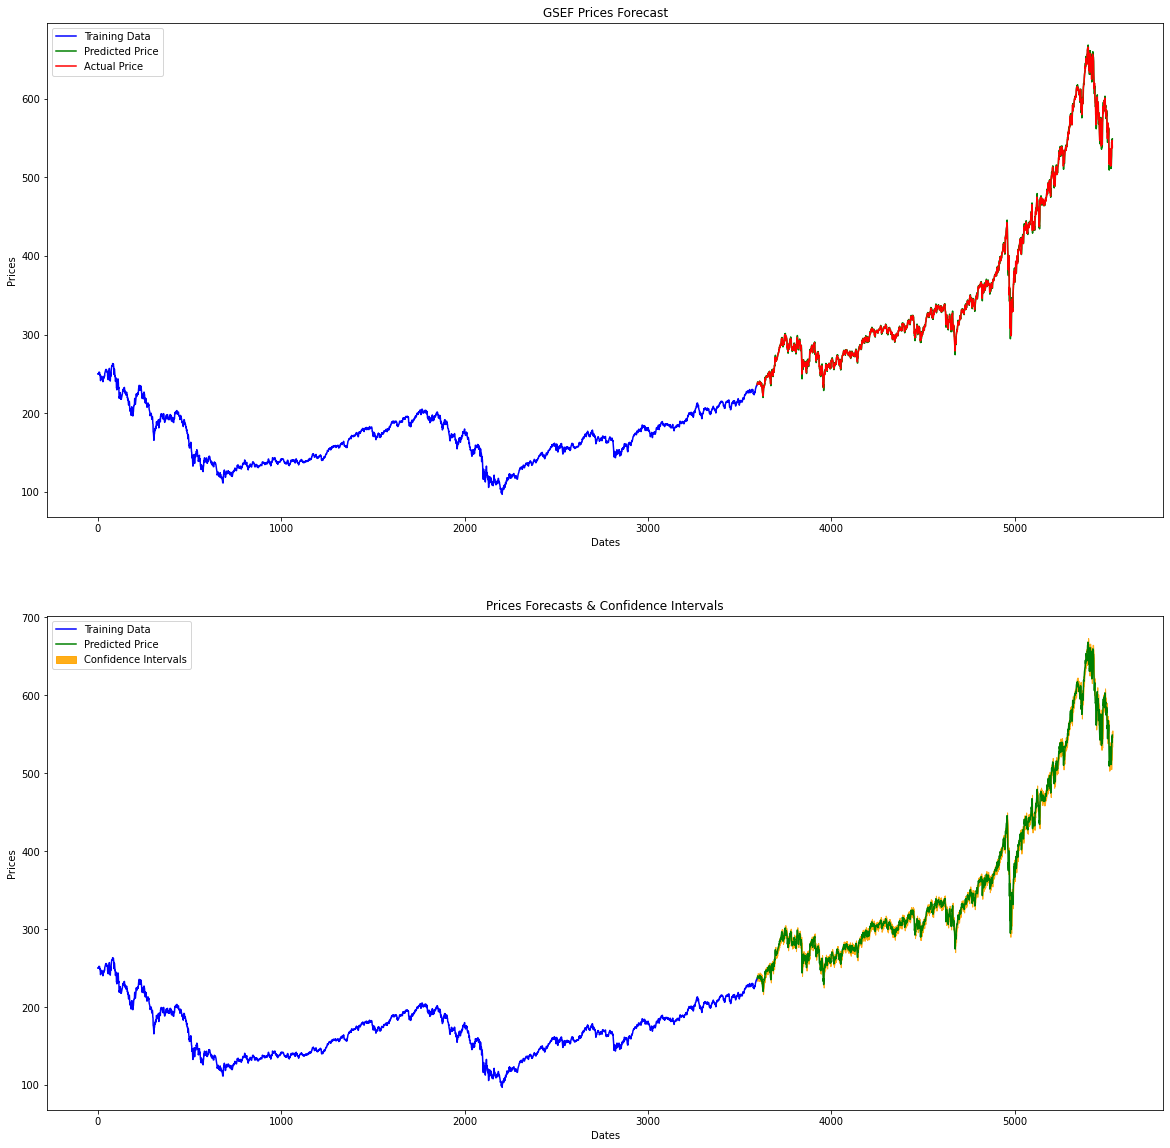

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(20, 20))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(test_data.index, forecasts, color='green', label='Predicted Price')

axes[0].plot(test_data.index, y_test, color='red', label='Actual Price')
axes[0].set_title('GSEF Prices Forecast')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')


axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(test_data.index, forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Forecasts & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

axes[1].legend()

## Forecast the Price for the next 10 business days

In [115]:
# Forecast the Price for the next 10 business days
forecast= model.predict(start= len(gsef_selected), end= len(gsef_selected)+10, type= 'levels')

following_day= gsef_selected.Date.iloc[-1]+ pd.DateOffset(1)

index_future_dates= pd.date_range(start= following_day, periods=10, freq='B')

forecast_df = pd.DataFrame(forecast, columns = ['Forecasted Closing Price'], index= pd.DatetimeIndex(index_future_dates)).reset_index(level=0)

forecast_df.rename(columns={'index': 'Date'}, inplace=True)

existing_with_forecast= pd.concat([gsef_selected, forecast_df], ignore_index=True, sort=False)

## Append only new forecast data points to the existing ones and calculate the difference between the forecast and known closing prices

In [117]:
# Read the existing forecast
existing_forecast= pd.read_csv('gsef_output/gsef_forecast.csv', parse_dates=['Date'], dayfirst=True)

concat_forecast= pd.concat([existing_forecast, forecast_df], ignore_index=True).drop_duplicates('Date', keep='first').reset_index(drop=True).sort_values(by="Date")

concat_forecast= pd.merge(concat_forecast, gsef_selected, on='Date', how='left')

concat_forecast = concat_forecast.drop(['Close'],axis=1)

#concat_forecast['Closing Price'] = concat_forecast['Close_x'].where(concat_forecast['Close_x'].notnull(), concat_forecast['Close_y'])

#concat_forecast = concat_forecast.drop(['Close_x','Close_y'],axis=1)

concat_forecast['Difference']= concat_forecast['Forecasted Closing Price'] - concat_forecast['Closing Price']

#concat_forecast_cols= ['Date', 'Closing Price', 'Forecasted Closing Price', 'Difference']

#concat_forecast = concat_forecast[concat_forecast_cols]

## Save the updated forecasts, real closing prices and the difference between the forecast and known closing price for the corresponding dates

In [124]:
# Output the appended forecast to a CSV file
concat_forecast.to_csv('gsef_output/gsef_forecast.csv', index=False)

## Visualise and save the forecasts

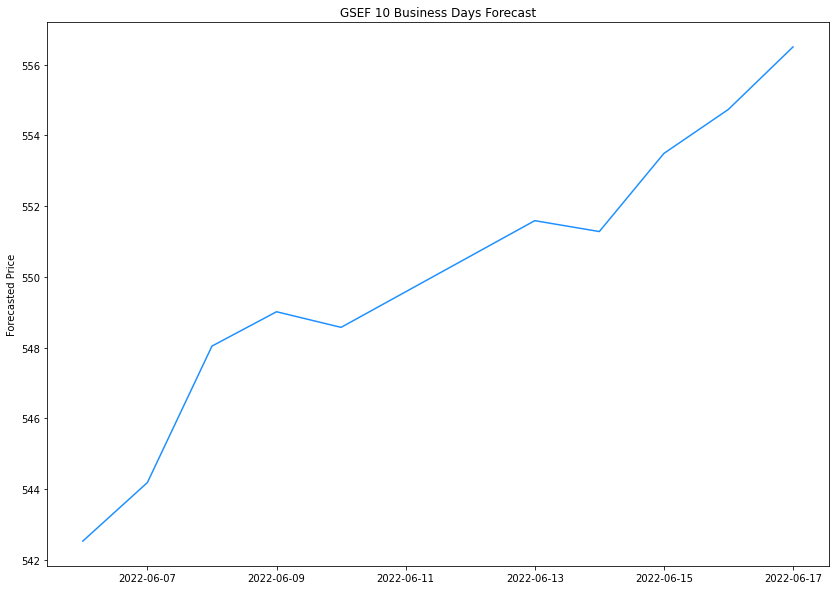

In [16]:
plt.figure(figsize=(14, 10))

plt.plot(existing_with_forecast['Date'][-10:], existing_with_forecast['Forecasted Closing Price'][-10:], color='dodgerblue')

#ax1.set_xticks(np.arange(len(existing_with_forecast['Date'][-10:])))

#plt.yticks(np.arange(existing_with_forecast['Close'][-10:]))

plt.ylabel('Forecasted Price')

plt.title('GSEF 10 Business Days Forecast')

forecast_chart= 'gsef_output/gsef_10_day_forecast.png'

import os
if os.path.exists(forecast_chart):
  os.remove(forecast_chart)
else:
  print("The Forecast chart didn't exist and it has been created.")

plt.savefig('gsef_output/gsef_10_day_forecast.png', dpi=100)

#plt.show()

## Time Elapsed

In [17]:
# Calculate and print the time elapsed to run ETL process and the date and time of the latest run
time_elapsed = timeit.default_timer() - start_time

time_elapsed_minutes = int((time_elapsed % 3600) // 60)

time_elapsed_seconds = int(time_elapsed % 60)

now = datetime.datetime.now()

print("\nSuccess! Your GSEF forecast has been updated in {} minutes and {} seconds on {}".format(time_elapsed_minutes, time_elapsed_seconds, now.strftime("%Y-%m-%d %H:%M:%S")))


Success! Your GSEF forecast has been updated in 15 minutes and 26 seconds on 2022-06-05 22:48:05
